# Sakib Bin Faruque Rusho
# ID: 2010776109

# Cell 1: Imports and Setup

In [ ]:

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.grid'] = False

# Cell 2: Model Loading

In [ ]:

pretrained_model = tf.keras.applications.ResNet50V2(
    include_top=True,
    weights='imagenet'
)
pretrained_model.trainable = False
decode_predictions = tf.keras.applications.resnet_v2.decode_predictions

# Cell 3: Preprocessing Functions

In [ ]:

def preprocess(image):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.resnet_v2.preprocess_input(image)
    return image[None, ...]

def get_imagenet_label(probs):
    return decode_predictions(probs, top=1)[0][0]

# Cell 4: Load and Display Original Image

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


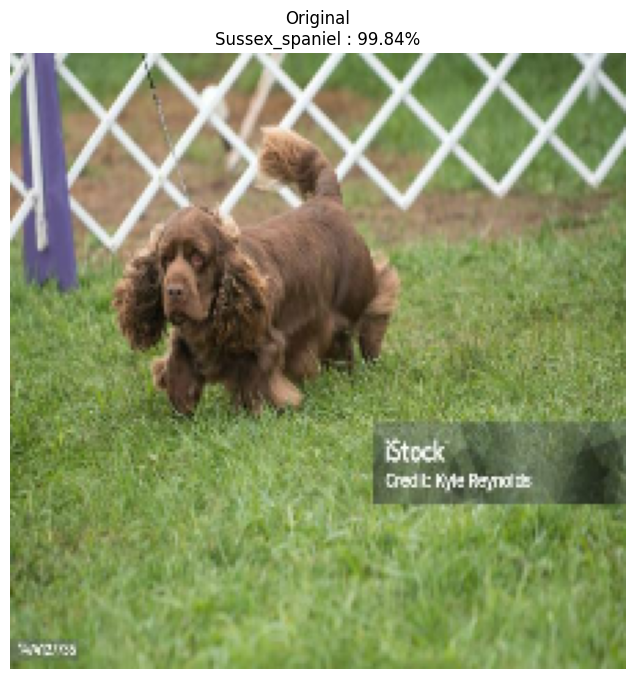

In [ ]:

image_path = tf.keras.utils.get_file(
    'ss.jpg',
    'https://media.istockphoto.com/id/1474127735/photo/sussex-spaniel-walking-in-dog-show-ring.jpg'
)
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)
image = preprocess(image)

# Display original
plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)
_, label, conf = get_imagenet_label(pretrained_model.predict(image))
plt.title(f'Original\n{label} : {conf*100:.2f}%')
plt.axis('off')
plt.show()

# Cell 5: Adversarial Setup

In [ ]:

loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = pretrained_model(input_image)
        loss = loss_object(input_label, prediction)
    gradient = tape.gradient(loss, input_image)
    return tf.sign(gradient)

target_class = 118  # Dungeness crab
label = tf.one_hot(target_class, 1000)
label = tf.reshape(label, (1, 1000))
perturbations = create_adversarial_pattern(image, label)

# Cell 6: Visualize Perturbations

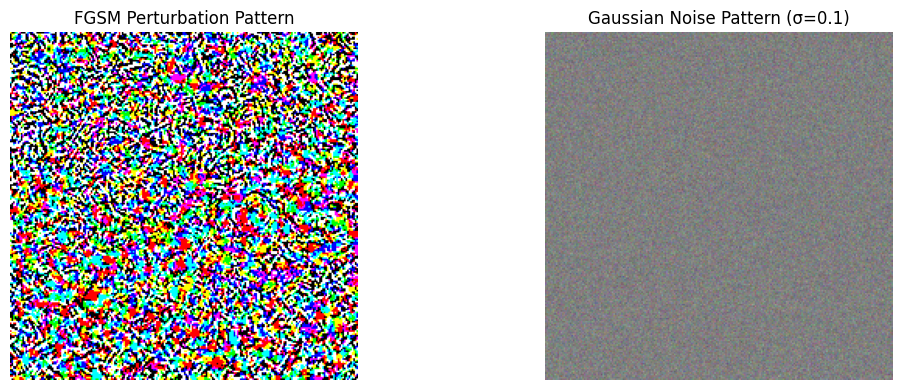

In [ ]:

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.imshow(perturbations[0] * 0.5 + 0.5)
plt.title("FGSM Perturbation Pattern")
plt.axis('off')

plt.subplot(1, 2, 2)
gaussian_noise = tf.random.normal(shape=image.shape, mean=0, stddev=0.1)
plt.imshow(gaussian_noise[0] * 0.5 + 0.5)
plt.title("Gaussian Noise Pattern (σ=0.1)")
plt.axis('off')

plt.tight_layout()
plt.show()

# Cell 7: Attack Comparison Function

In [ ]:
def compare_attacks(original, epsilons=[0.01, 0.1, 0.2], noise_stds=[0.05, 0.1, 0.2]):
    num_cols = max(len(epsilons), len(noise_stds)) + 1  # +1 for original
    plt.figure(figsize=(22, 12))  # Increased figure size

    # Original Image (Top Left)
    plt.subplot(2, num_cols, 1)
    _, label, conf = get_imagenet_label(pretrained_model.predict(original))
    plt.imshow(original[0] * 0.5 + 0.5)
    plt.title(f'Original\n{label}\nConf: {conf*100:.2f}%',
             fontsize=12, pad=12, weight='bold')  # Larger font
    plt.axis('off')

    # FGSM Attacks (Top Row)
    for i, eps in enumerate(epsilons, start=2):
        adv_x = original + eps * perturbations
        adv_x = tf.clip_by_value(adv_x, -1, 1)
        _, label, conf = get_imagenet_label(pretrained_model.predict(adv_x))

        ax = plt.subplot(2, num_cols, i)
        ax.imshow(adv_x[0] * 0.5 + 0.5)
        plt.title(f'FGSM Attack\nε={eps}\n{label}\nConf: {conf*100:.2f}%',
                 fontsize=12, pad=12, weight='bold')
        plt.axis('off')

    # Gaussian Noise Attacks (Bottom Row)
    for j, std in enumerate(noise_stds, start=num_cols+1):
        noisy_img = original + tf.random.normal(shape=original.shape, stddev=std)
        noisy_img = tf.clip_by_value(noisy_img, -1, 1)
        _, label, conf = get_imagenet_label(pretrained_model.predict(noisy_img))

        ax = plt.subplot(2, num_cols, j)
        img = ax.imshow(noisy_img[0] * 0.5 + 0.5)
        plt.title(f'Gaussian Noise\nσ={std}\n{label}\nConf: {conf*100:.2f}%',
                 fontsize=12, pad=12, weight='bold')
        plt.axis('off')

    # Add empty subplots for alignment if needed
    max_attacks = max(len(epsilons), len(noise_stds))
    for k in range(len(epsilons)+1, max_attacks+2):
        plt.subplot(2, num_cols, k)
        plt.axis('off')
    for k in range(num_cols + len(noise_stds)+1, 2*num_cols+1):
        plt.subplot(2, num_cols, k)
        plt.axis('off')

    plt.tight_layout(pad=3.0)  # Increased padding
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


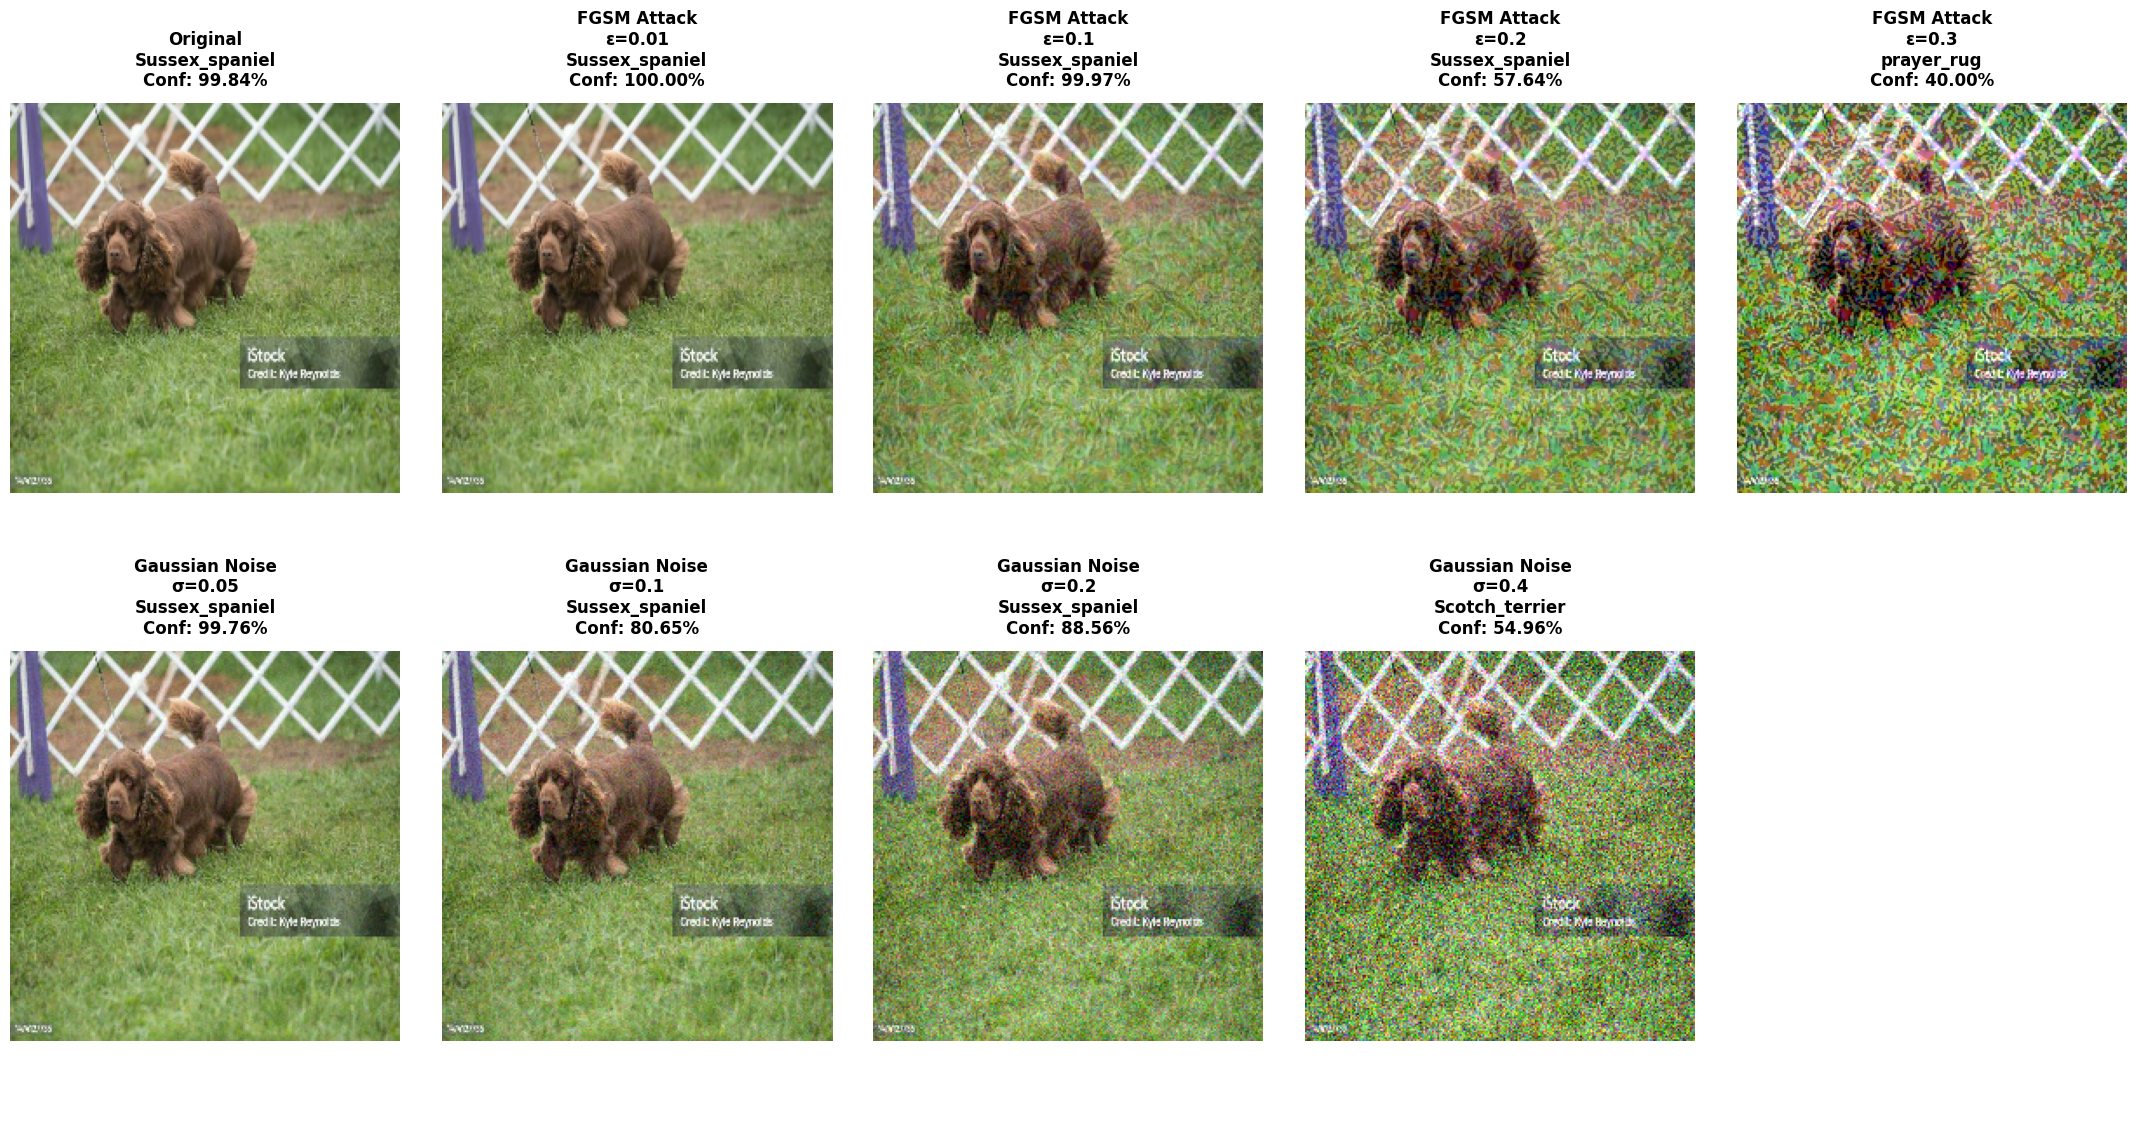

In [ ]:
compare_attacks(image,
                epsilons=[0.01, 0.1, 0.2, 0.3],
                noise_stds=[0.05, 0.1, 0.2, 0.4])